In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('C:/Training/Academy/Statistics (Python)/Datasets/AirPassengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')
timeseries.shape

(144, 1)

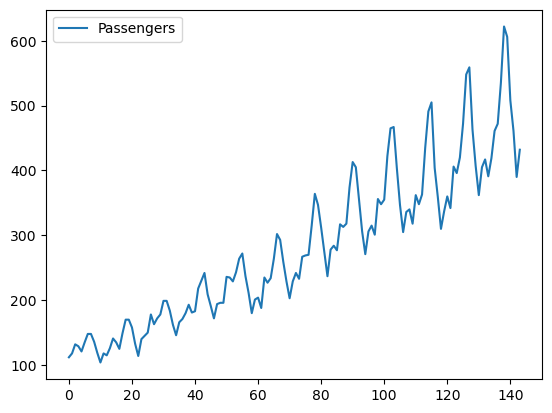

In [3]:
df.plot()
plt.show()

### train-test split for time series

In [4]:
len(timeseries)

144

In [5]:
train_size = int(len(timeseries) * 0.9)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [6]:
train.shape, test.shape

((129, 1), (15, 1))

In [7]:
mm = MinMaxScaler()
train = mm.fit_transform(train)
test = mm.transform(test)

In [8]:
type(train)

numpy.ndarray

In [9]:
dataset=train
lookback=4
X, y = [], []
for i in range(len(dataset)-lookback):
    feature = dataset[i:i+lookback]
    target = dataset[i+1:i+lookback+1]
    X.append(feature)
    y.append(target)

In [10]:
np.array(X)[:,:,0][0]

array([0.01758242, 0.03076923, 0.06153846, 0.05494505], dtype=float32)

In [11]:
np.array(y)[:,:,0][0]

array([0.03076923, 0.06153846, 0.05494505, 0.03736264], dtype=float32)

### Creating a Dataset

In [12]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [13]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

C:\Users\Sanjay Sane\AppData\Local\Temp\ipykernel_26492\778121417.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  return torch.tensor(X), torch.tensor(y)


In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([125, 4, 1]),
 torch.Size([125, 4, 1]),
 torch.Size([11, 4, 1]),
 torch.Size([11, 4, 1]))

### Model Definition

In [15]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

### Initialization and settings

In [16]:
torch.manual_seed(23)
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

### Training Loop

In [17]:
n_epochs = 1000
for epoch in range(0, n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch+1, train_rmse, test_rmse))



Epoch 1: train RMSE 0.3085, test RMSE 0.7098
Epoch 101: train RMSE 0.0615, test RMSE 0.1069
Epoch 201: train RMSE 0.0608, test RMSE 0.1097
Epoch 301: train RMSE 0.0601, test RMSE 0.1161
Epoch 401: train RMSE 0.0608, test RMSE 0.1183
Epoch 501: train RMSE 0.0586, test RMSE 0.1300
Epoch 601: train RMSE 0.0582, test RMSE 0.1260
Epoch 701: train RMSE 0.0576, test RMSE 0.1405
Epoch 801: train RMSE 0.0576, test RMSE 0.1446
Epoch 901: train RMSE 0.0562, test RMSE 0.1589


In [18]:
print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch+1, train_rmse, test_rmse))

Epoch 1000: train RMSE 0.0562, test RMSE 0.1589


In [19]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

In [20]:
train_plot = mm.inverse_transform( train_plot )
test_plot = mm.inverse_transform( test_plot )

### Learning Curve

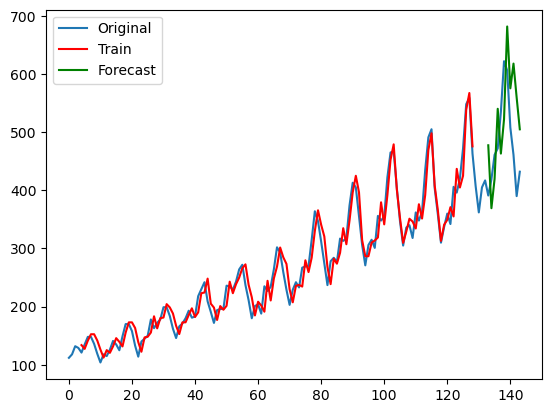

In [21]:
plt.plot(timeseries, label="Original")
plt.plot(train_plot, c='r', label="Train")
plt.plot(test_plot, c='g', label="Forecast")
plt.legend(loc='best')
plt.show()